# Manolo Ramírez Pintor - A01706155
## Unsafe Furry Content Detector - CNN

This CNN will determine if a digital art furry piece is safe or not safe content, some use cases for this could be using it for filtering content on safe artist platforms or any other social media platforms.

First, we will access to our data via Google Drive.

In [1]:
# Acceder a Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd "/content/drive/MyDrive/IA_2/Furry"
!ls

/content/drive/MyDrive/IA_2/Furry
augmented      images		 images.zip	 mi_modelo_n.h5
augmented.zip  images_ver_2.zip  mi_modelo_7.h5


Since I want to work with the fastest speed possible, I will copy all the images to the local storage so they can get processed quickly.

In [3]:
# Copiar info a almacenamiento local
!cp -r /content/drive/MyDrive/IA_2/Furry/images_ver_2.zip /content

In [4]:
# Descomprimir todo
%%capture
%cd /content
!unzip images_ver_2.zip

Just because I wanted to try Colab Processing Credits, I check the GPU info with this cell of code.

In [5]:
# Ver info de la GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat May 27 06:15:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Data Augmentation

To make the Data Augmentation part, we will use a ```ImageDataGenerator``` to generate new images and store them to the RAM while we do the training process.






### Transformations applied:

Some of the following transformations applied were taken because of how the data needs to be managed.

* I set a rotation range of 25 because I don't feel like big rotations are going to make the model learn correctly. 

* The shift ranges are minimal in order to avoid the model learning from very stretched images that could add noise. 

* The shear range is moderated so the model can still know how things should look like. 

* The zoom range is minimal too so we don't lose important details of the images.

I think most of these transformations are good but in moderated values, it really depends on the kind of images you want your model to learn from too.

In [6]:
# Importar librerías necesarias
from tensorflow.keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Crear el objeto TensorBoard
tb_callback = TensorBoard(log_dir="logs")

# Cambiar Path a almacenamiento local
path = "/content"

# Establecer los directorios de imagenes, train y test
base_dir = 'images'
train_dir = os.path.join(base_dir,'train')
test_dir = os.path.join(base_dir, 'test')

# Crear el Datagen para hacer augmentation
train_datagen = ImageDataGenerator(
								rescale = 1./255,
								rotation_range = 25,
								width_shift_range = 0.1,
								height_shift_range = 0.1,
								shear_range = 0.2,
								zoom_range = 0.15,
								horizontal_flip = True)
							
# Crear directorio augmented
!mkdir augmented

Now, with the ```ImageDataGenerator``` created, we will display 5 test images to see if our Data Gen is working properly and adjust some parameters further.

Found 2610 images belonging to 2 classes.


<Figure size 640x480 with 0 Axes>

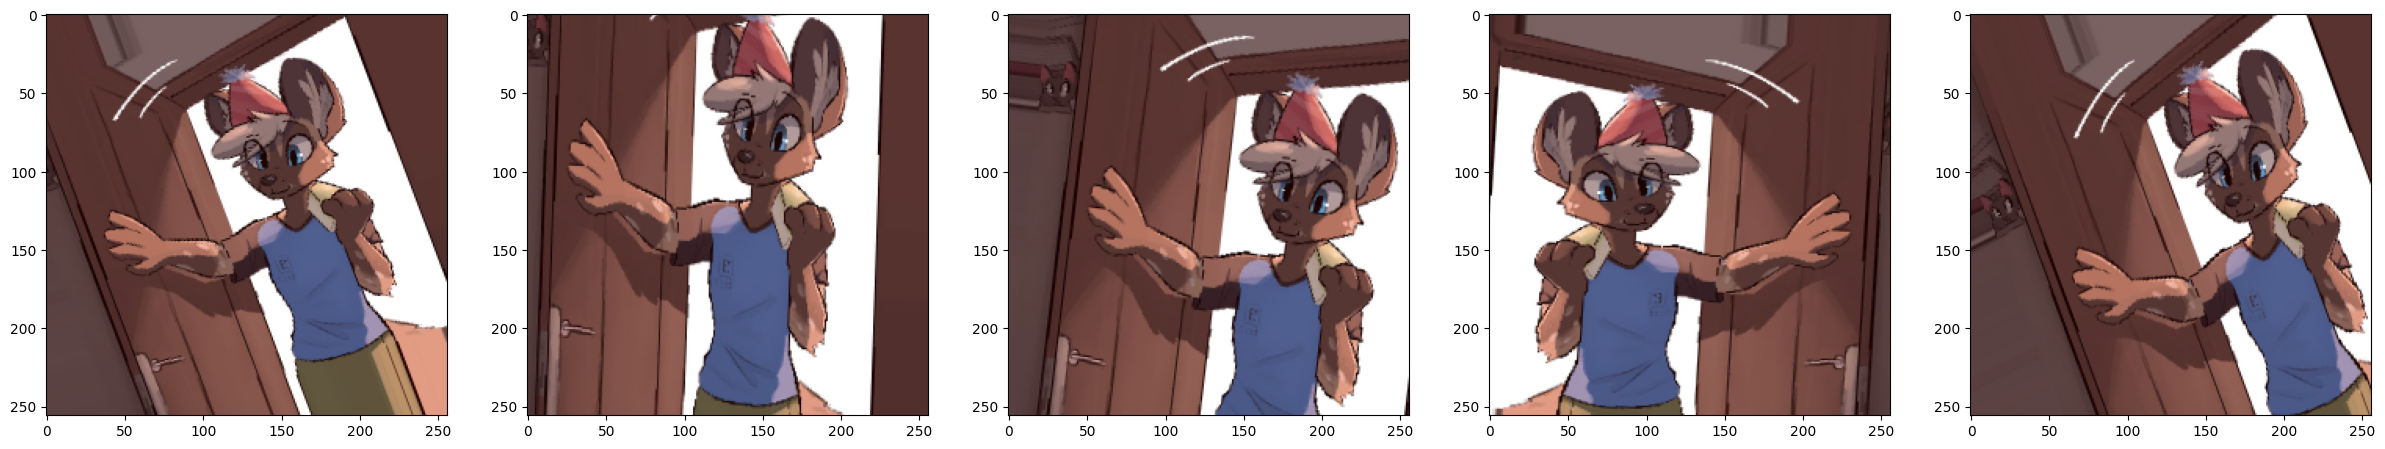

In [16]:
# Visualizar las imagenes aplicadas con Data Augmentation
train_generator = train_datagen.flow_from_directory(
									train_dir,
									target_size = (256, 256),
									batch_size = 1,
									class_mode ='binary')


plt.figure()
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1, 5, figsize=(30, 8)) 

for i in range(5) :
  axarr[i].imshow(train_generator[0][0][0])

Now, we will take 8 different images with the imageDataGen applied on them and see how they look.

Aditionally, I applied a blur to censor unsafe images only for the previews, the censorship isn't applied when the model is training.

Found 2610 images belonging to 2 classes.
(8, 150, 150, 3)
[1. 0. 0. 0. 0. 1. 0. 1.]


<Figure size 640x480 with 0 Axes>

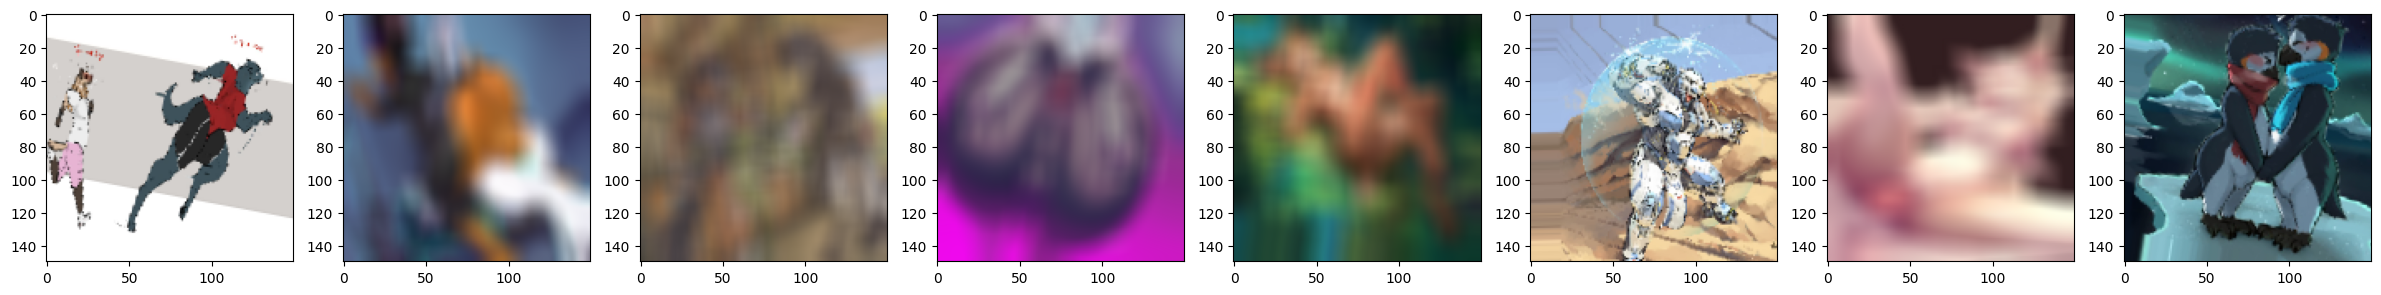

In [17]:
# Censurador
import cv2

train_generator = train_datagen.flow_from_directory(
							train_dir,
							target_size = (150, 150),
							batch_size = 8,
							class_mode ='binary'
							)


images , labels = train_generator[0]

print(images.shape)
print(labels)

plt.figure()
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1, images.shape[0], figsize=(30, 4)) 

for i in range(images.shape[0]): 
	if labels[i] == 0:
		# Mostrar la imagen con blur, kernelSize 10,10
		blurred_image = cv2.blur(images[i], ksize=(15, 15))
		axarr[i].imshow(blurred_image)
	else:
		axarr[i].imshow(images[i])

We prepare the generator for the training process and aditionally, we apply some settings to save the augmented images on a folder on jpg format (to save some space) to see what did the model trained with.

In [7]:
train_generator = train_datagen.flow_from_directory(
							train_dir,
							target_size = (256, 256),
							batch_size = 32,
							class_mode ='binary',
							save_to_dir= path + '/augmented', # Almacenamiento local
              save_prefix='aug',
              save_format='jpg' # Ahorra espacio en disco
							)

Found 2610 images belonging to 2 classes.


# Convolutional Neural Network Model:

We will use this convolutional neural network based on how the [VGG16 model](https://datagen.tech/guides/computer-vision/vgg16/) was made to take advantage of having a base and modify it depending on what we see while training.

Based on [VGG16](https://datagen.tech/guides/computer-vision/vgg16/), I took a high resolution input like they did and added convolutional filters using using (3,3) kernel sizes and ReLu activations because that function only gives us positive numbers and if there's any negatives we just get zero, so that's good for our model training process.

With the usage of Pooling layers, we reduce the number of parameters created by the convolutional steps.

Finally, we get our output doing a dense of only 1 parameter using a sigmoid function to get 0 to 1 values.


In [8]:
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
 
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape = (256,256, 3)))
model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Dropout(0.5)) # Capa de dropout después de la primera capa convolucional
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2)) # Capa de dropout después de la segunda capa convolucional
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Dropout(0.5)) # Capa de dropout después de la tercera capa convolucional
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3)) # Capa de dropout después de la cuarta capa convolucional
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
#model.add(layers.Dropout(0.5)) # Capa de dropout después de la capa densa
model.add(layers.Dense(1, activation="sigmoid"))

model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), 
              loss="binary_crossentropy", 
							metrics=["acc"])


#model.compile(loss = 'binary_crossentropy',
#						optimizer=optimizers.RMSprop(learning_rate=2e-5),
#						metrics=['acc'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 62, 62, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       7

Epoch 1/25
82/82 [==============================] - 169s 2s/step - loss: 0.6677 - acc: 0.6195
Epoch 2/25
82/82 [==============================] - 152s 2s/step - loss: 0.6555 - acc: 0.6268
Epoch 3/25
82/82 [==============================] - 153s 2s/step - loss: 0.6499 - acc: 0.6280
Epoch 4/25
82/82 [==============================] - 152s 2s/step - loss: 0.6348 - acc: 0.6368
Epoch 5/25
82/82 [==============================] - 151s 2s/step - loss: 0.6153 - acc: 0.6559
Epoch 6/25
82/82 [==============================] - 148s 2s/step - loss: 0.5989 - acc: 0.6759
Epoch 7/25
82/82 [==============================] - 148s 2s/step - loss: 0.5928 - acc: 0.6816
Epoch 8/25
82/82 [==============================] - 147s 2s/step - loss: 0.5855 - acc: 0.6966
Epoch 9/25
82/82 [==============================] - 148s 2s/step - loss: 0.5802 - acc: 0.6973
Epoch 10/25
82/82 [==============================] - 146s 2s/step - loss: 0.5821 - acc: 0.6824
Epoch 11/25
82/82 [==============================] - 146s 2

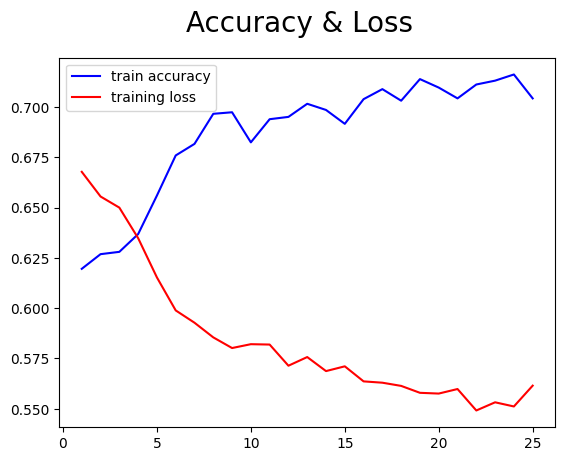

In [9]:
# Entrenamos el modelo
history = model.fit(
						train_generator, 
						epochs = 25,
						callbacks=[tb_callback]) # Añadir el callback al método fit

# Integramos variables para graficar el rendimiento del entrenamiento:
acc = history.history['acc']
loss = history.history['loss']

epochs = range(1, len(acc)+1)

fig = plt.figure()
fig.suptitle('Accuracy & Loss', fontsize=20)
plt.plot(epochs,acc,'b',label='train accuracy')
plt.plot(epochs,loss, 'r', label ='training loss')
plt.legend(loc="upper left")
plt.show()

# Guardar el modelo inmediatamente al finalizar el entrenamiento
model.save('mi_modelo_n.h5') # Guarda como HDF5
!cp mi_modelo_n.h5 /content/drive/MyDrive/IA_2/Furry # Guarda a Drive

## Model Evaluation

Now, we evaluate the model with the images we have in the test folder.

The results are below our training accuracy, so we can say this model is overfitting in some way.

To make things a bit more clear, we will take a look into the confusion matrix.

In [10]:
# Evaluando el modelo
test_datagen = ImageDataGenerator(1./255)
test_generator = test_datagen.flow_from_directory(
					test_dir,
					target_size = (256, 256),
					batch_size = 20,
					class_mode= 'binary')

test_loss, test_acc = model.evaluate(test_generator, steps = 25)
print('\ntest acc :\n', test_acc)

Found 241 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


13/25 [==============>...............] - ETA: 10s - loss: 46.0807 - acc: 0.6515

25/25 [==============================] - 12s 436ms/step - loss: 46.0807 - acc: 0.6515

test acc :
 0.6514523029327393


# Confusion Matrix

De esta parte sí no logro entender exactamente a lo que se refieren estos datos, por lo que un poco de guía me servirá.

In [11]:
test_imgs = test_generator[0][0]
test_labels = test_generator[0][1]
print(test_labels)


predictions = model.predict(test_imgs)
classes_x = predictions.T
classes_x

[0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1.]
1/1 [==============================] - 0s 118ms/step


array([[1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 0.0000000e+00,
        7.2130005e-27, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00,
        1.0000000e+00, 0.0000000e+00, 1.0000000e+00, 1.0000000e+00,
        0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 1.0000000e+00,
        1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 5.5817368e-33]],
      dtype=float32)

In [12]:
from tensorflow.math import confusion_matrix

print('Model         ', 'test loss            ', ' test accuracy ') 
print('Original      ', test_loss, '   ', test_acc)

mat = confusion_matrix(classes_x[0], test_labels)
print('         ', 'label nsfw ', ' label sfw') 
print('pred nsfw    ', np.array(mat[0][0]), "          ", np.array(mat[0][1])) 
print('pred sfw     ', np.array(mat[1][0]), "          ", np.array(mat[1][1]))

Model          test loss              test accuracy 
Original       46.0806770324707     0.6514523029327393
          label nsfw   label sfw
pred nsfw     5            3
pred sfw      5            7


## Probando el modelo de forma interactiva

In [15]:
# Librerías necesarias
from keras.preprocessing import image 
from keras.utils import load_img
from keras.utils import img_to_array
from keras import models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
import cv2

# Creamos el directorio para subir nuestras imágenes
!mkdir images2

# Cargamos el modelo a memoria
model = models.load_model("./mi_modelo_n.h5")

mkdir: cannot create directory ‘images2’: File exists


### Descomentar imagen a probar.

El resultado sale antes de la imagen en sí

1/1 [==============================] - 0s 30ms/step
[[0.1968424]]
class  0 confindence
NSFW


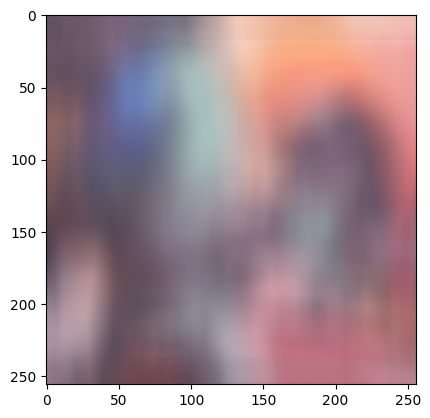

In [40]:
# Descomenta la imagen que quieres usar:

#test_img = './images2/fox_12_sleeping.jpg'
#test_img = './images2/fox_3.jpg'
#test_img = './images2/fox_4.jpg'
#test_img = './images2/fox_7_couch.jpg'
#test_img = './images2/fox_9_clothes.jpg'
#test_img = './images2/tiger_shark_1.jpg'
#test_img = './images2/vrc_fursona.jpg'
#test_img = './images2/nsfw_1.jpg'
#test_img = './images2/nsfw_2.jpg'
test_img = './images2/nsfw_3.jpg'
#test_img = './images2/nsfw_4.jpg'
#test_img = './images2/nsfw_5.jpg'
#test_img = './images2/nsfw_6.jpg'
#test_img = './images2/nsfw_7.jpg'
#test_img = './images2/nsfw_8.jpg'
#test_img = './images2/nsfw_9.jpg'
#test_img = './images2/nsfw_10.jpg'
#test_img = './images2/nsfw_11.jpg'
#test_img = './images2/nsfw_12.jpg'
#test_img = './images2/nsfw_13.jpg'

img_path = test_img 

# Preprocesado
img = load_img(img_path,  target_size=(256,256))
img_tensor = img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis = 0)
img_tensor /= 255.

# Respuesta del modelo
confidence = model.predict(img_tensor)
predict_class = (confidence > 0.5).astype("int32")
print (confidence)
print ("class ", predict_class[0][0], "confindence", )

isnsfw = False

# Predicción 
if predict_class[0][0] == 0:
  print("NSFW")
  isnsfw = True
else:
  print("SFW")

# Plot de la imagen a predecir
blurred_image = cv2.blur(img_tensor[0], ksize=(35, 35))
plt.imshow(blurred_image)
plt.show()

## Conclusiones

Al final, el modelo aprendió principalmente características como lo que es notablemente no seguro pero sigue presentando problemas para contenido nsfw que a la vez tiene indicios de sugerencia.

Para mejorar esto, se reclasificarán las imágenes sugerentes y se enviarán de la carpeta "SFW" a "NSFW" para obtener una mejor detección. 

¡Gracias! :)